In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold
from sklearn.preprocessing import power_transform
from sklearn.metrics import confusion_matrix
from boruta import BorutaPy
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
import pickle

In [3]:
target_column='Survived'
visualize_column = 'Sex'

def prob_surviving(visualize_column):
    group = train_df.groupby(by=[visualize_column])

    for index, g in group:
        print(f'value = {index}')
        survived = g[target_column].sum()
        total = g[target_column].count()
        print(survived,' Survived from ',total)
        print(f'probability of surviving knowing {index} is {round(survived/total,2)}')
        print(f'probability of dying knowing {index} is {round(1-survived/total,2)}','\n\n')

In [4]:
def cluster_feature(org_df,n_clusters,column,random_state=29):
    
    df=org_df[org_df['trainable']==1]
    
    df=df[df[column].notnull()].copy()
    classify_feature=KMeans(n_clusters=n_clusters,random_state=random_state).fit(df[column].values.reshape([-1,1]))

    #df[column]=classify_feature.labels_
    #df['Age']=df['Age'].apply(lambda x: int(x/10)*10 if not np.isnan(x) else np.nan)
    org_df[column]=org_df[column].apply( lambda x:
        x if np.isnan(x) else classify_feature.predict([[x]])[0])
    #df[column]
    print(str(column)+' culsters are: \n',classify_feature.cluster_centers_,'\n')
    return classify_feature,org_df

In [5]:
def convert_int(df,column):
    
    df[column]=df[column].str.extract(r'((\s?)\d+$)')
    df[column]=df[column].str.replace(' ','').apply(lambda x: int(x) if type(x)==str else x)
    
    return df

def get_mean_unbiased(df,column,low_per,high_per):
    
    cal_df=df[df[column].notnull()]
    
    s=cal_df[column].quantile([low_per,high_per])
    val_min,val_max=s.iloc[0],s.iloc[1]
    
    cal_df=cal_df[(cal_df[column]>val_min) & (cal_df[column]<val_max)]
    
    return cal_df[column].mean()

In [6]:
def fill_missing_age_wtitle(df,func=np.max):
    #sns.countplot(x='Title',hue='Age',data=df)
    #df['Title'].unique()
    #sns.countplot(x='Age',hue='Title',data=df)
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

    #Fill age nan values with the most probable value according to the title of the person
    df['Age']=df.apply(lambda row: func(gr_age[row['Title']].index.values) if np.isnan(row['Age']) else row['Age'],axis=1)
    print(df['Age'])
    return df

In [7]:
def fill_embarked_wticket(df,column='Ticket'):

    df['Embarked']=df.apply(lambda row: np.max(gr_ticket[row[column]].index.values) if type(row['Embarked'])==float else row['Embarked'],axis=1)
    
    return df

In [8]:
def reorder_clusters(clusters,df,column):
    '''
    clusters is the output of kmean.cluster_centers_
    '''
    clusters=np.array(clusters).ravel()
    print(clusters)
    ordered_clusters=np.sort(clusters)# sort in ascending order
    
    reorder_dict={}
    for cluster_id in range(len(clusters)):
        val=clusters[cluster_id]
        new_cluster_id=np.where(ordered_clusters==val)# get the index of the val in ordered cluster
        reorder_dict[cluster_id]=new_cluster_id[0][0]
    
    #reorder dictionary maps the current value to its supposed valu if reordered.
    #for example cluster 0 of age may have center of 53. if the clusters were ordered, then it should
    #be cluster 3. thus, this dictionary has the current cluster id (0) as key and the cluster id if
    #reordered as value
    
    df[column]=df[column].apply(lambda x: reorder_dict[int(x)])
    
    print(reorder_dict)
    return ordered_clusters,df
    

<h1 style="color: #00FF00"> LOAD THE DATA </h1>

In [9]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [11]:
pd.isna(train_df).sum()/len(train_df)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

<p>20% of the data does not contain Age. It can still be used</p>
<p>While 77% of the data does not contain a Cabin value. It will not be used since there are a lot of missing values.</p>

In [12]:
pd.isna(test_df).sum()/len(test_df)

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

<h1 style="color: #00FF00"> Visualization </h1>

In [13]:
for feature in ['Sex','Pclass','Embarked']:
    print(feature)
    prob_surviving(feature)

Sex
value = female
233  Survived from  314
probability of surviving knowing female is 0.74
probability of dying knowing female is 0.26 


value = male
109  Survived from  577
probability of surviving knowing male is 0.19
probability of dying knowing male is 0.81 


Pclass
value = 1
136  Survived from  216
probability of surviving knowing 1 is 0.63
probability of dying knowing 1 is 0.37 


value = 2
87  Survived from  184
probability of surviving knowing 2 is 0.47
probability of dying knowing 2 is 0.53 


value = 3
119  Survived from  491
probability of surviving knowing 3 is 0.24
probability of dying knowing 3 is 0.76 


Embarked
value = C
93  Survived from  168
probability of surviving knowing C is 0.55
probability of dying knowing C is 0.45 


value = Q
30  Survived from  77
probability of surviving knowing Q is 0.39
probability of dying knowing Q is 0.61 


value = S
217  Survived from  644
probability of surviving knowing S is 0.34
probability of dying knowing S is 0.66 




<AxesSubplot:xlabel='Survived', ylabel='count'>

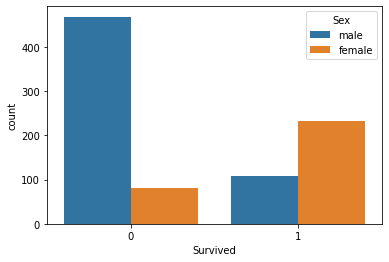

In [14]:
sns.countplot(x=target_column,hue='Sex',data=train_df)

<AxesSubplot:xlabel='Survived', ylabel='count'>

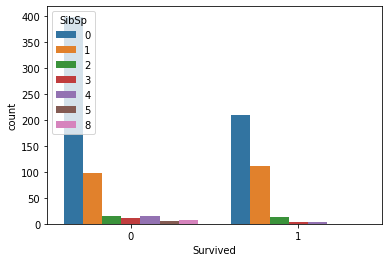

In [15]:
sns.countplot(x=target_column,hue='SibSp',data=train_df)

<AxesSubplot:xlabel='Survived', ylabel='count'>

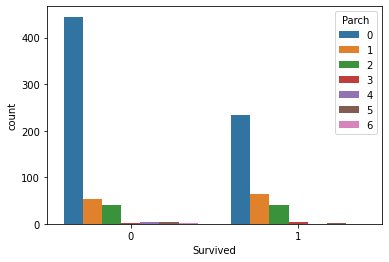

In [16]:
sns.countplot(x=target_column,hue='Parch',data=train_df)

<AxesSubplot:xlabel='Survived', ylabel='count'>

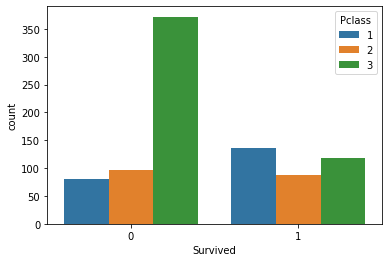

In [17]:
sns.countplot(x=target_column,hue='Pclass',data=train_df)

<AxesSubplot:xlabel='Survived', ylabel='count'>

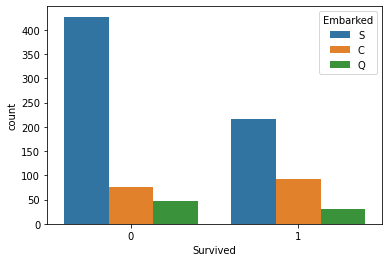

In [18]:
sns.countplot(x=target_column,hue='Embarked',data=train_df)

In [19]:
df=train_df.copy()

<h1 style="color: #00FF00"> Prepare The Data </h1>

In [20]:
Tdf=train_df.copy()
Tdf['trainable']=1

Tsdf=test_df.copy()
Tsdf['trainable']=0

total_df=pd.concat([Tdf,Tsdf])
total_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,trainable
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


I want to point to these 2 notebooks for pointing out a great feature 'Family_Survival':

[blood is thicker than water friendship forever](http://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever)

[simple end to end ml workflow top 5 score](https://www.kaggle.com/josh24990/simple-end-to-end-ml-workflow-top-5-score)

In [21]:
random_state=29

total_df['family_size']=total_df['Parch']+total_df['SibSp']+1
total_df['last_name']=total_df['Name'].apply(lambda x: str.split(x, ",")[0])
total_df['Title']=total_df['Name'].str.extract(r'(,\s(\w+|\w+\s\w+)\.)')[1]

df=total_df[total_df['trainable']==1]

allowed_vals=['Mr','Mrs','Miss','Master','Dr','Major']

total_df.loc[~total_df['Title'].isin(allowed_vals), 'Title'] = 'Rare'

#do KMeans on Age
age_classify,total_df=cluster_feature(total_df,n_clusters=4,column='Age',random_state=random_state)

#Fill the missing Age values using Title column
gr_age=total_df.groupby(['Title','Age'])['PassengerId'].count()
total_df=fill_missing_age_wtitle(total_df,func=np.max)

#fill the missing Fare values according to the Pclass values.
#The higher the class the more likely the fare will increase.
df=total_df[total_df['trainable']==1]
class_mean=df[['Pclass','Fare']].groupby('Pclass').mean()
total_df['Fare']=total_df.apply(lambda row: class_mean.loc[row['Pclass']].values[0] if np.isnan(row['Fare']) else row['Fare'],axis=1)

#next i will add 2 a great feature i found in 2 other notebooks. This feature greatly increased my
#score.
#generate a family information group
default_survival_chance = 0.5
total_df['Family_Survival'] = default_survival_chance

# Grouping by last name and fare gives you groups of families
for grp, grp_df in total_df[['Survived','Name', 'last_name', 'Fare', 'Ticket', 'PassengerId','Sex',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['last_name', 'Fare']):
    
    #if the family group has more than one member, then it is a family
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            smean=grp_df.drop(ind)['Survived'].mean()
            smean= 0.4 if np.isnan(smean) else smean
            passID = row['PassengerId']
            total_df.loc[total_df['PassengerId'] == passID, 'prob_survival']=smean#np.log10(smean+0.0001)
            if (smax == 1.0):
                total_df.loc[total_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin == 0.0):
                total_df.loc[total_df['PassengerId'] == passID, 'Family_Survival'] = 0

#grouping by ticket gives you groups that are expected to have gone together to the trip
for _, grp_df in total_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                smean=grp_df.drop(ind)['Survived'].mean()
                smean=0.4 if np.isnan(smean) else smean
                passID = row['PassengerId']
                total_df.loc[total_df['PassengerId'] == passID, 'prob_survival']=smean#np.log10(smean+0.0001)
                if (smax == 1.0):
                    total_df.loc[total_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    total_df.loc[total_df['PassengerId'] == passID, 'Family_Survival'] = 0

total_df['prob_survival']=total_df['prob_survival'].fillna(total_df['Family_Survival'])
total_df['prob_survival']=total_df['prob_survival'].apply(lambda x: 1/(1+np.exp(-x)))
# total_df['prob_survival']=total_df['prob_survival'].replace(0,0.000001)
# total_df['prob_survival']=power_transform((total_df['prob_survival']).values.reshape(-1, 1), method='box-cox')
Sprob_classify,total_df=cluster_feature(total_df,n_clusters=7,column='prob_survival',random_state=random_state)
#4
#replace the 0 Fare values with a small number (wrt fare) and apply a log10 on the values.
total_df['Fare']=total_df['Fare'].replace(0,0.00001)
total_df['Fare']=total_df['Fare'].apply(lambda x: np.log(x+1))
#one of the cited notebooks suggests that the fare is for the family. Supposing this theory stands,
#then divide the fare(log fare to be more accurate) by the family size to have something like 
#fare/family member
total_df['fare_per_fsize']=total_df['Fare'].values/total_df['family_size'].values
fare_classify,total_df=cluster_feature(total_df,n_clusters=3,column='fare_per_fsize',random_state=random_state)

#I tried some method to fill the missing embarked and all gave 'S' on train set \
#while test set does not have missing values. Thus, i just did fill missing embarked values with 'S'
total_df['Embarked']=total_df['Embarked'].fillna('S')
#This next 2 columns were taken from another notebooks
#these new features seems to be useful

total_df['Sex']=total_df['Sex'].apply(lambda x: 1 if x=='male' else 0)

total_df['Embarked']=total_df['Embarked'].apply(lambda x: 0 if x=='S' else (1 if x == 'C' else 2))

print('Null values: ',pd.isna(total_df).sum()/len(total_df))
print('train_df: ',len(train_df))
print('test_df: ',len(test_df))
print('total_df: ',len(total_df))
print('columns: ',total_df.columns)

total_df

Age culsters are: 
 [[53.        ]
 [21.31578947]
 [ 5.00239437]
 [34.02371542]] 

0      1.0
1      3.0
2      1.0
3      3.0
4      3.0
      ... 
413    3.0
414    3.0
415    3.0
416    3.0
417    2.0
Name: Age, Length: 1309, dtype: float64
prob_survival culsters are: 
 [[0.59868766]
 [0.73105858]
 [0.5       ]
 [0.62245933]
 [0.66075637]
 [0.58257021]
 [0.69705928]] 

fare_per_fsize culsters are: 
 [[0.95593577]
 [2.23469952]
 [3.84632805]] 

Null values:  PassengerId        0.000000
Survived           0.319328
Pclass             0.000000
Name               0.000000
Sex                0.000000
Age                0.000000
SibSp              0.000000
Parch              0.000000
Ticket             0.000000
Fare               0.000000
Cabin              0.774637
Embarked           0.000000
trainable          0.000000
family_size        0.000000
last_name          0.000000
Title              0.000000
Family_Survival    0.000000
prob_survival      0.000000
fare_per_fsize     0.000000
dty

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,trainable,family_size,last_name,Title,Family_Survival,prob_survival,fare_per_fsize
0,1,0.0,3,"Braund, Mr. Owen Harris",1,1.0,1,0,A/5 21171,2.110213,NaN,0,1,2,Braund,Mr,0.5,3,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3.0,1,0,PC 17599,4.280593,C85,1,1,2,Cumings,Mrs,0.5,0,1
2,3,1.0,3,"Heikkinen, Miss. Laina",0,1.0,0,0,STON/O2. 3101282,2.188856,NaN,0,1,1,Heikkinen,Miss,0.5,3,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,3.0,1,0,113803,3.990834,C123,0,1,2,Futrelle,Mrs,0.0,2,1
4,5,0.0,3,"Allen, Mr. William Henry",1,3.0,0,0,373450,2.202765,NaN,0,1,1,Allen,Mr,0.5,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",1,3.0,0,0,A.5. 3236,2.202765,NaN,0,0,1,Spector,Mr,0.5,3,1
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,3.0,0,0,PC 17758,4.699571,C105,1,0,1,Oliva y Ocana,Rare,1.0,3,2
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,3.0,0,0,SOTON/O.Q. 3101262,2.110213,NaN,0,0,1,Saether,Mr,0.5,3,1
416,1308,NaN,3,"Ware, Mr. Frederick",1,3.0,0,0,359309,2.202765,NaN,0,0,1,Ware,Mr,0.5,3,1


In [22]:
age_clusters,total_df=reorder_clusters(age_classify.cluster_centers_,total_df,'Age')
prob_survival_clusters,total_df=reorder_clusters(Sprob_classify.cluster_centers_,total_df,'prob_survival')
fare_clusters,total_df=reorder_clusters(fare_classify.cluster_centers_,total_df,'fare_per_fsize')

[53.         21.31578947  5.00239437 34.02371542]
{0: 3, 1: 1, 2: 0, 3: 2}
[0.59868766 0.73105858 0.5        0.62245933 0.66075637 0.58257021
 0.69705928]
{0: 2, 1: 6, 2: 0, 3: 3, 4: 4, 5: 1, 6: 5}
[0.95593577 2.23469952 3.84632805]
{0: 0, 1: 1, 2: 2}


<AxesSubplot:>

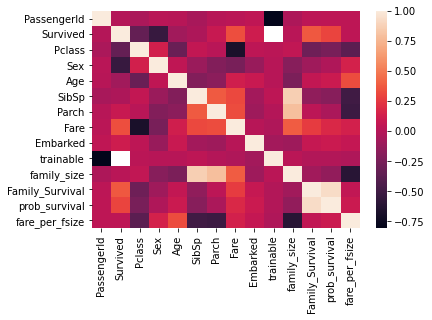

In [23]:
sns.heatmap(total_df.corr())

<h1 style="color: #00FF00"> Generate the results </h1>

In [24]:
drop_features=['Survived','PassengerId','SibSp','Parch','Ticket','trainable','last_name','Name',
               'Title','Cabin','Embarked','Family_Survival','family_size','Fare']

X_train=total_df[total_df['trainable']==1]
X_test=total_df[total_df['trainable']==0]

X_train=X_train.drop(columns=drop_features).values
y_train=total_df[total_df['trainable']==1]['Survived'].values.ravel()#.reshape((-1,1))

X_test=X_test.drop(columns=drop_features).values
y_test=total_df[total_df['trainable']==0][['PassengerId','Survived']]#.reshape((-1,1))

In [25]:
cv=5
verbose=1
# parameters={
# #     'max_depth':np.arange(5,16,5),
# #     'min_samples_split':np.arange(10,30,5),
#     'max_leaf_nodes':[5,8,10,12,15],
#     'min_samples_leaf':[3,5,8,10],
# #     'n_estimators':[100,150,200,250],
#     'min_samples_split':[5,10,15,20]
# }

forest_classifier=RandomForestClassifier(n_estimators=100,max_depth=10,max_leaf_nodes=12,
                            min_samples_leaf=10,min_samples_split=5,n_jobs=-1,random_state=27)

# clf=GridSearchCV(forest_classifier,parameters,verbose=verbose,cv=cv)
# clf.fit(X_train,y_train)


# best_estimator=clf.best_estimator_
# print(X_train)
forest_classifier.fit(X_train,y_train)

# y_test['Survived']=best_estimator.predict(X_test).astype(np.int32)
y_test['Survived']=forest_classifier.predict(X_test).astype(np.int32)
y_test=y_test.set_index('PassengerId')

In [26]:
y_test.to_csv('result.csv')

<h1 style="color: #00FF00"> Model Explainability </h1>
In this part I did some model explainability to check that the model somehow represents the visualizations above. Furthermore, it is giving prediction that actually makes sense. <br/>
These ideas were taken from kaggles courses.

In [27]:
X_train=total_df[total_df['trainable']==1].drop(columns=drop_features)
y_train=total_df[total_df['trainable']==1]['Survived']

train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, random_state=27)

rf_model=RandomForestClassifier(n_estimators=100,max_depth=10,max_leaf_nodes=12,
                           min_samples_leaf=10,min_samples_split=5,n_jobs=-1,random_state=27)
rf_model.fit(train_X,train_y)
print(np.sum(rf_model.predict(val_X)==val_y)/len(val_X))

0.8340807174887892


,predictive negative,predictive positive,total
true negative,127.00,11.00,138.0
true positive,26.00,59.00,85.0
total,153.00,70.00,223.0
precision,0.83,0.84,NaN


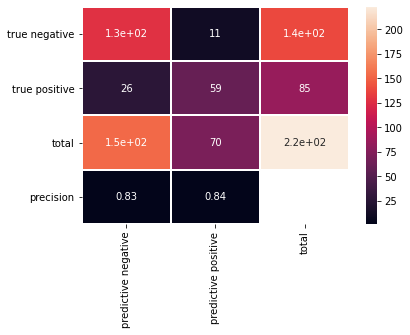

In [28]:
y_pred=rf_model.predict(val_X)
conf_mat=confusion_matrix(val_y,y_pred)

conf_df=pd.DataFrame(conf_mat,
                     columns=['predictive negative','predictive positive'],
                     index=['true negative','true positive'])
conf_df['total']=conf_df.sum(axis=1)
conf_df.loc['total']=conf_df.sum(axis=0)

conf_df.loc['precision',['predictive negative']]=conf_df.loc['true negative',['predictive negative']]/conf_df.loc['total',['predictive negative']]
conf_df.loc['precision',['predictive positive']]=conf_df.loc['true positive',['predictive positive']]/conf_df.loc['total',['predictive positive']]

conf_df=conf_df.applymap(lambda x: int(x) if x.is_integer() else np.round(x,2))

sns.heatmap(conf_df,annot=True,linewidths=2)
conf_df

In [29]:
#rf_model=forest_classifier
perm = PermutationImportance(rf_model, random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = total_df.drop(columns=drop_features).columns.values)

Weight,Feature
0.2444 ± 0.0133,Sex
0.0577 ± 0.0060,prob_survival
0.0321 ± 0.0109,Pclass
0.0139 ± 0.0097,Age
0.0011 ± 0.0032,fare_per_fsize


Age 0 is around 5 years
Age 1 is around 21 years
Age 2 is around 34 years
Age 3 is around 52 years


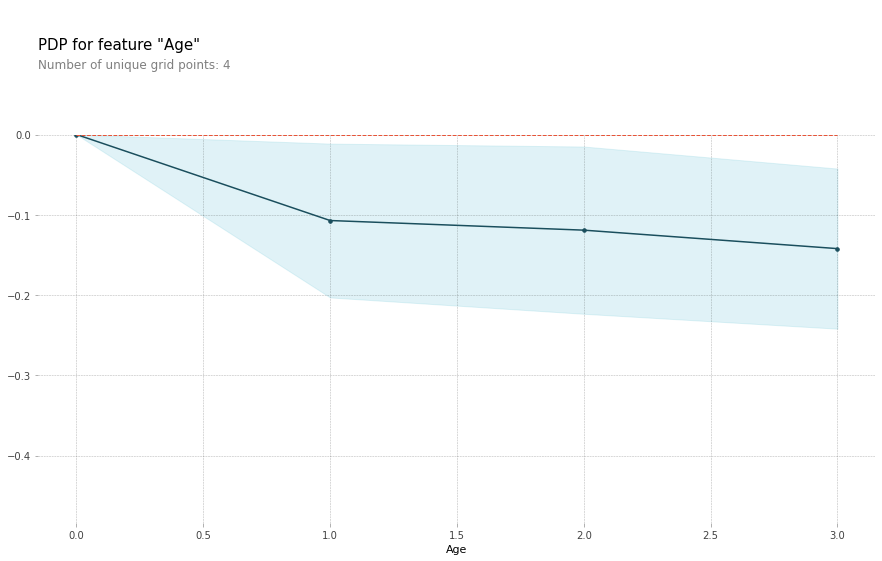

In [30]:
from pdpbox import pdp, get_dataset, info_plots

age_classify
#rf_model=forest_classifier

feature_to_plot='Age'
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=total_df[total_df['trainable']==1],
                            feature=feature_to_plot,
                            model_features=total_df.drop(columns=drop_features).columns)

for index,age in enumerate(age_clusters):
    print(f'Age {index} is around {int(age)} years')


# plot it
pdp.pdp_plot(pdp_goals, feature_to_plot)
plt.show()

The 2 figures above shows that the model learned the relationship between age and survival rate.<br/>
In the titanic (or the movie at least), the priority was women and children. The graph and plot shows that the kids of age around 5 had a better chance of surviving. For those around 21 and 34 had less surviving chances. Yet, they were higher than people of age around 52 and higher. It is typical that the older the person the less its ability to survive and they sacrifice for the younger generation.<br/>
The curves shows that as the age increases, the surviving chances decreases. I think it is logical enough.

Sex 0 is female
Sex 1 is male


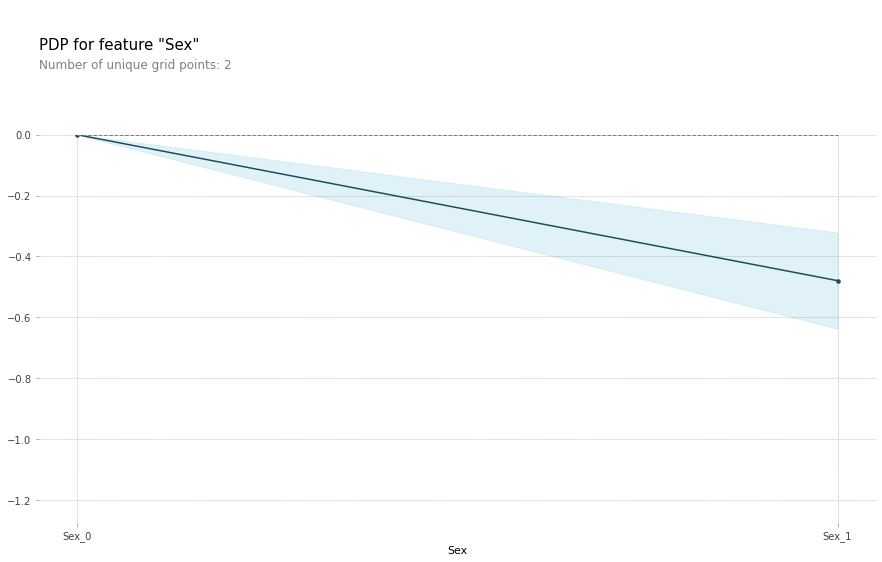

In [31]:
#rf_model=forest_classifier

feature_to_plot='Sex'
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=total_df[total_df['trainable']==1],
                            feature=feature_to_plot,
                            model_features=total_df.drop(columns=drop_features).columns,)

print(f'Sex 0 is female')
print(f'Sex 1 is male')

# plot it
pdp.pdp_plot(pdp_goals, feature_to_plot)
plt.show()

From the first section we know females had better chance to survive than men. This relation was learned by the model.

prob_survival 0 is around 0.5
prob_survival 1 is around 0.583
prob_survival 2 is around 0.599
prob_survival 3 is around 0.622
prob_survival 4 is around 0.661
prob_survival 5 is around 0.697
prob_survival 6 is around 0.731


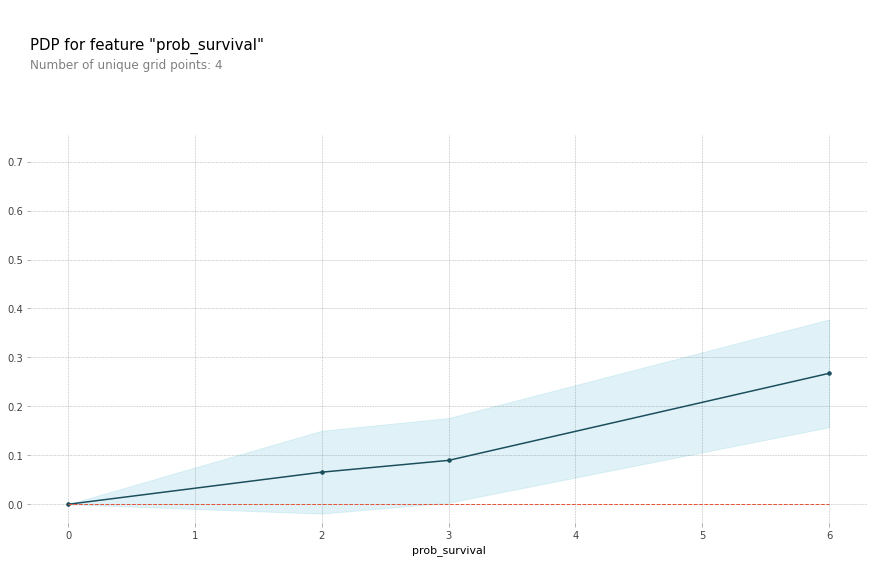

In [32]:
#rf_model=forest_classifier

feature_to_plot='prob_survival'
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=total_df[total_df['trainable']==1],
                            feature=feature_to_plot,
                            model_features=total_df.drop(columns=drop_features).columns)

# print(prob_survival_clusters)
for index,val in enumerate(prob_survival_clusters):
    print(f'prob_survival {index} is around {np.round(prob_survival_clusters[index],3)}')
# plot it
pdp.pdp_plot(pdp_goals, feature_to_plot)
plt.show()

It is expected that as probability of survival increases, the better the chance of actually surviving.

fare_per_fsize 0 is around 0.956
fare_per_fsize 1 is around 2.235
fare_per_fsize 2 is around 3.846


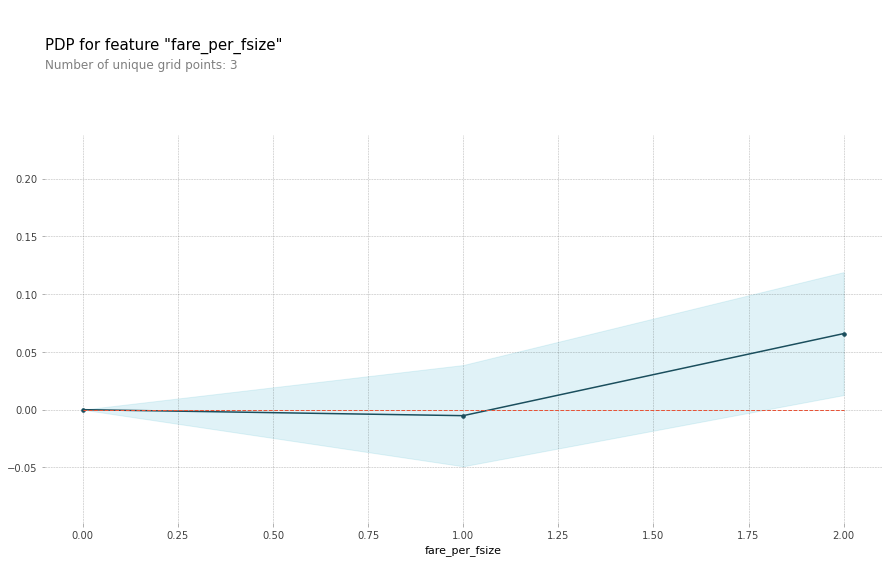

In [33]:
#rf_model=forest_classifier

feature_to_plot='fare_per_fsize'
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=total_df[total_df['trainable']==1],
                            feature=feature_to_plot,
                            model_features=total_df.drop(columns=drop_features).columns)

for index,val in enumerate(fare_clusters):
    print(f'fare_per_fsize {index} is around {np.round(fare_clusters[index],3)}')
    
# plot it
pdp.pdp_plot(pdp_goals, feature_to_plot)

plt.show()

we can treate this feature as log fare per family member. As fare increases, the richer the person. According to the plots, the richier the person, the higher the surviving chance. Sure there is an element of randomness (specially that the priority was to save women and children and then men) which can be seen between 0 and 2.

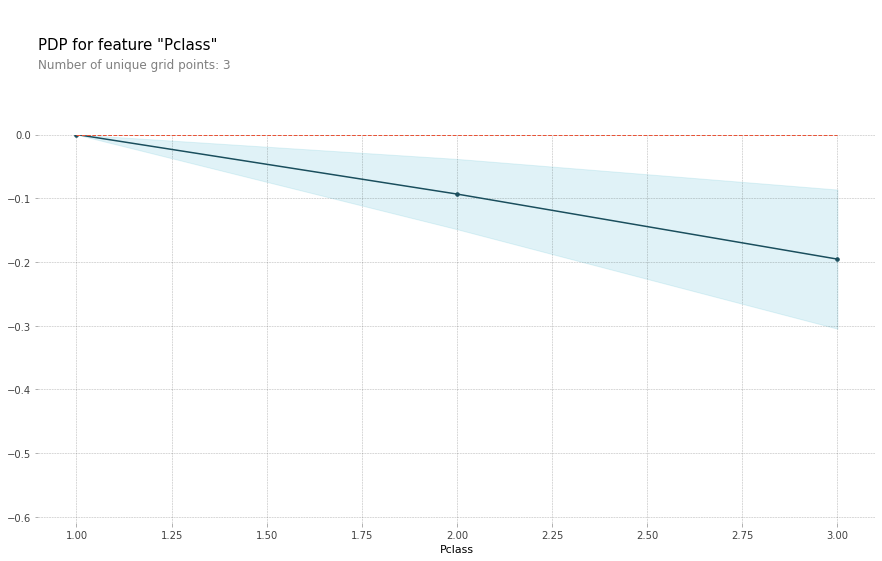

In [34]:
#rf_model=forest_classifier

feature_to_plot='Pclass'
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=total_df[total_df['trainable']==1],
                            feature=feature_to_plot,
                            model_features=total_df.drop(columns=drop_features).columns)

# plot it
pdp.pdp_plot(pdp_goals, feature_to_plot)
plt.show()

This plot also verifies the relation between surviving and Pclass. class 1 is higher than class 2 higher than class 3. the higher the class, the higher the surviving chances.

<h1 style="color: #00FF00"> CONCLUSION </h1>
As an overall, the model did learn the same information we saw while visualizing the data. Thus, the model did learn useful relationships from the data. I hope this notebook helps you.